In [1]:
import os
import csv
import pickle
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
dir = os.getcwd()
list_dir = os.listdir(dir)

if 'labels' in list_dir:
    print('Label Folder is already unzipped')
else:
    file_name = (dir+'\labels.zip')
    with ZipFile(file_name,'r') as zip:
        zip.extractall()
if 'Data' in list_dir:
    print('Data Folder is already unzipped')
else:
    label_name = (dir+'Data.zip')
    with ZipFile(label_name,'r') as zip:
        zip.extractall()

Label Folder is already unzipped
Data Folder is already unzipped


In [3]:
labels_dir = os.getcwd()+'\labels'
data_dir = os.getcwd()+'\Data'
labels_list = os.listdir(labels_dir)
data_list = os.listdir(data_dir)

In [4]:
txt = []
for index in range(2, len(labels_list)): #start from new dataset
    label = labels_list[index]
    txt.append(os.path.join(labels_dir, label))

In [5]:
dt = []
for index in range(2, len(data_list)): #start from new dataset
    d = data_list[index]
    dt.append(os.path.join(data_dir, d))

In [6]:
def extract_label(txt):
    clean_vars = []
    with open(txt, 'r') as csvfile:
    # with open(r'C:\Users\phili\techlabs\eth_sms\labels\SMS_064_Körperlage.txt', 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=';', quotechar=",")
        for row in reader:
            # clean up your file here and append it to the list
            clean_vars.append([char for char in row if char])

    my_string=mystring = ' '.join(map(str,clean_vars[1]))
    start_date = my_string.split(":",1)[1]
    start = start_date[0:11] #get only the date

    list = clean_vars[6:] #get the labels
    df = pd.DataFrame(list, columns=['time','Position'])
    # start = pd.to_datetime(start, format='%d%m%Y')
    df.time = df.time.str.replace(',','.')
    df.time = df.time.str.lstrip()
    # df.time = df.time.str.replace(" ", "", n = 1)
    df.time = df.time.apply(lambda x: ' '.join((start, x))) # add date
    # df.time= pd.to_datetime(df.time)
    # morning_hour = df.iloc[-1]['time'].hour '%m/%d/%Y %H:%M:%S.%f'
    df.time = pd.to_datetime(df['time'], format=' %d.%m.%Y %H:%M:%S.%f')
    df.time = pd.to_datetime(df.time).apply(lambda x: x + pd.DateOffset(days=1) if x.hour <= 10 else x) # corect the date after 0 o'clock
    # df.time = pd.to_datetime(df.time,format='%Y/%m/%d %H:%M:%S.%f')
    # df_end = df[df['Position']!=' A']
    df_end = df
    df_end = df_end.reset_index().drop(columns= ['index'])
    df_end['end'] = df_end['time'].shift(-1) # get the duration
    df_end['end'] = np.where(df_end['end'].isnull(), df_end['time'], df_end['end'])
    return df_end



In [14]:
def get_data(dt):
    data = pd.read_pickle(dt)
    data = data.reset_index()
    data = data.rename(columns={"index": "time", "matData": "pressure"})
    data['time'] = pd.to_datetime(data['time'],unit='ms')
    df_new = data.drop_duplicates(subset='time', keep='first').reset_index().drop(columns= ['index']) #drop with exact date and hours and get the first one
    df_new['end'] = df_new['time'].shift(-1) # get the duration
    df_new['end'] = np.where(df_new['end'].isnull(), df_new['time'], df_new['end'])
    df_new['time'] = df_new['time'] + pd.Timedelta(hours=1)
    df_new['end'] = df_new['end'] + pd.Timedelta(hours=1)
    df_new['label'] = 0
    return df_new

In [22]:
def get_date(txt,dt):

    start_data = []
    end_data = []
    start_label = []
    end_label = []
    name_col = []

    for tx, lb in zip(txt, dt):

        # try:
        df_end = extract_label(tx)
        df_new = get_data(lb)

        st_data = df_new.time.iloc[0]
        ed_data = df_new.time.iloc[-1]
        st_label = df_end.time.iloc[0]
        ed_label = df_end.time.iloc[-1]
        

        start_data.append(st_data)
        end_data.append(ed_data)
        start_label.append(st_label)
        end_label.append(ed_label)
        name_col.append(tx[-22:-4])

        # except :
        #     continue

    return start_data,end_data,start_label,end_label, name_col


In [23]:
start_data,end_data,start_label,end_label,name_col = get_date(txt,dt)

In [24]:
end_frame = pd.DataFrame([start_data,end_data,start_label,end_label,name_col]) 
end_frame = end_frame.transpose()
end_frame.columns=['start_data','end_data','start_label','end_label','name_patinet']
end_frame.to_csv('end_frame.csv')


In [25]:
end_frame

,start_data,end_data,start_label,end_label,name_patinet
0,2021-12-03 23:46:25.221,2021-12-04 06:09:59.267,2021-12-03 23:17:43.000,2021-12-04 05:57:39.250,SMS_033_Körperlage
1,2022-01-24 22:42:29.116,2022-01-25 08:11:59.940,2022-01-24 22:12:56.500,2022-01-25 08:12:33.500,SMS_043_Körperlage
2,2022-01-20 00:59:44.891,2022-01-20 05:29:58.847,2022-01-19 22:04:14.740,2022-01-20 05:56:01.250,SMS_044_Körperlage
3,2022-01-27 00:59:37.460,2022-01-27 06:12:59.187,2022-01-26 23:53:51.750,2022-01-27 06:13:20.000,SMS_045_Körperlage
4,2022-01-17 22:53:06.412,2022-01-18 08:25:58.820,2022-01-17 22:27:15.490,2022-01-18 08:26:32.750,SMS_046_Körperlage
5,2022-01-20 22:19:00.950,2022-01-21 05:29:59.581,2022-01-20 22:05:51.230,2022-01-21 05:50:25.000,SMS_047_Körperlage
6,2022-03-16 23:53:05.364,2022-03-17 06:00:59.300,2022-03-16 23:39:03.240,2022-03-17 06:18:35.000,SMS_049_Körperlage
7,2022-01-23 22:55:19.742,2022-01-24 05:31:59.008,2022-01-23 22:38:57.240,2022-01-24 05:56:25.250,SMS_050_Körperlage
8,2022-03-18 23:32:25.957,2022-03-19 05:29:59.372,2022-03-18 22:15:37.250,2022-03-19 05:33:39.000,SMS_064_Körperlage
9,2022-03-20 21:52:10.309,2022-03-21 05:29:59.029,2022-03-20 21:43:33.490,2022-03-21 05:34:14.500,SMS_067_Körperlage


In [26]:
def get_label(txt,dt):
    df_end = extract_label(txt)
    df_new = get_data(dt)
    for i in range(len(df_new['end'])):
        for j in range(len(df_end['time'])):

            if (df_new['time'][i] >= df_end['time'][j]) & (df_new['time'][i] <= df_end['end'][j]):
                df_new['label'][i] = df_end['Position'][j]
                break
            else:
                continue

    

    return df_new, df_end
    

In [27]:
# def get_image(txt,dt):
#     # if len(df_merged.label.unique()):

#     df_merged, df_end = get_label(txt,dt)
#     sample = df_merged.groupby('label').sample().reset_index().drop(columns=['index'])
#     print('Here is the unique label for this patient', df_merged.label.unique())

#     fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)

#     fig.suptitle('Sample of position', fontsize=20)

#     # Line plots
#     ax1.set_title(sample['label'][0])
#     ax1.imshow(sample['pressure'][0])

#     ax2.set_title(sample['label'][1])
#     ax2.imshow(sample['pressure'][1])

#     ax3.set_title(sample['label'][2])
#     ax3.imshow(sample['pressure'][2])

#     ax4.set_title(sample['label'][3])
#     im4 = ax4.imshow(sample['pressure'][3])

#     plt.tight_layout()
#     # Make space for title
#     plt.subplots_adjust(top=0.85)
#     plt.show()

#     df_merged.label.value_counts().plot.bar()

#     return df_merged, df_end

In [32]:
def get_image(txt,dt):
    # if len(df_merged.label.unique()):

    df_merged, df_end = get_label(txt,dt)
    sample = df_merged.groupby('label').sample().reset_index().drop(columns=['index'])
    # print('Here is the unique label for this patient', df_merged.label.unique())

    fig, axs = plt.subplots(1,len(sample.label),figsize=(15, 6),)
    fig.suptitle(f'{tx[-22:-4]}', fontsize=20)
    try:
        axs = axs.ravel()
    
        for i in range(len(sample.label)):

            axs[i].set_title(sample['label'][i])
            axs[i].imshow(sample['pressure'][i])
    
    except AttributeError:

        axs.set_title(sample['label'])
        axs.imshow(sample['pressure'])

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.savefig(f'image/{tx[-22:-4]}.png')
    plt.show()
    

    df_merged.label.value_counts().plot.bar()
    

    return df_merged, df_end

In [29]:
merged_dir = ("merged")
check = os.path.isdir(merged_dir)

# If folder doesn't exist, then create it.
if not check:
    os.makedirs(merged_dir)
    print("created folder : ", merged_dir)

else:
    print(merged_dir, "folder already exists.")

image_dir = ("image")
check = os.path.isdir(image_dir)

# If folder doesn't exist, then create it.
if not check:
    os.makedirs(image_dir)
    print("created folder : ", image_dir)

else:
    print(image_dir, "folder already exists.")


video_dir = ("video")
check = os.path.isdir(video_dir)

# If folder doesn't exist, then create it.
if not check:
    os.makedirs(video_dir)
    print("created folder : ", video_dir)

else:
    print(video_dir, "folder already exists.")


merged folder already exists.
image folder already exists.
video folder already exists.


In [30]:
merged_dir = os.getcwd()+'\merged'
for tx, lb in zip(txt, dt):
    try:
        df_merged, df_end = get_label(tx,lb)
        df_merged.to_csv(os.path.join(merged_dir,f'{tx[-22:-4]}.csv'))
    except EOFError:
        print(f'no data for',tx[-22:-4])

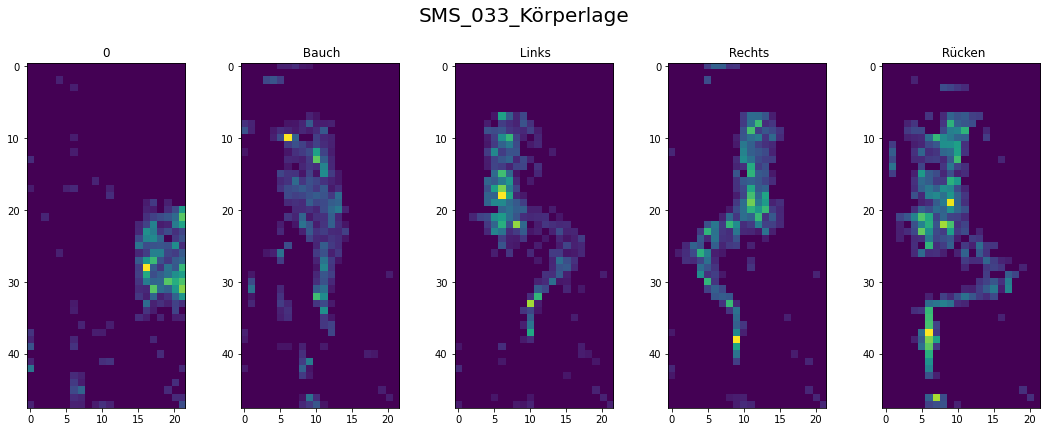

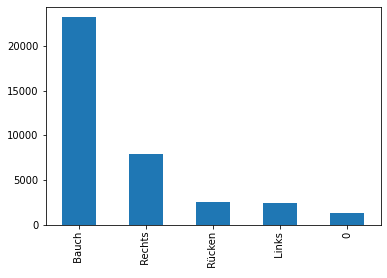

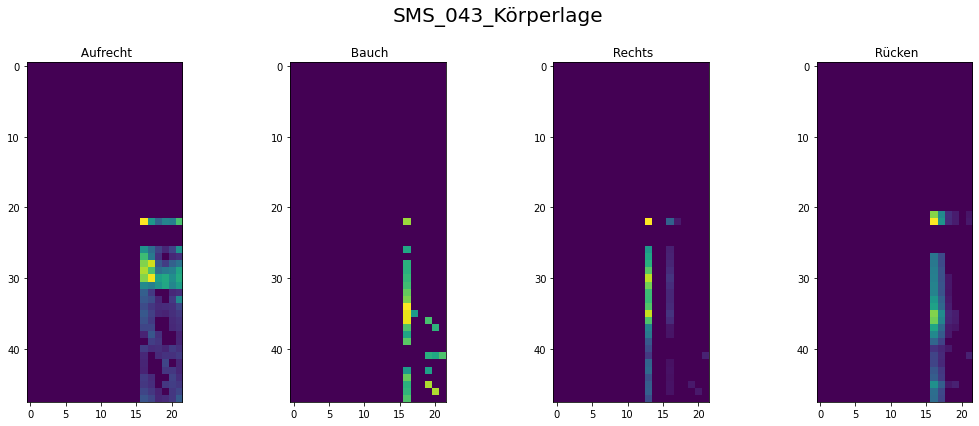

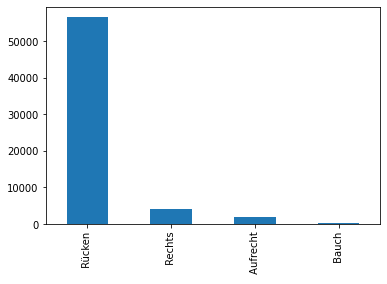

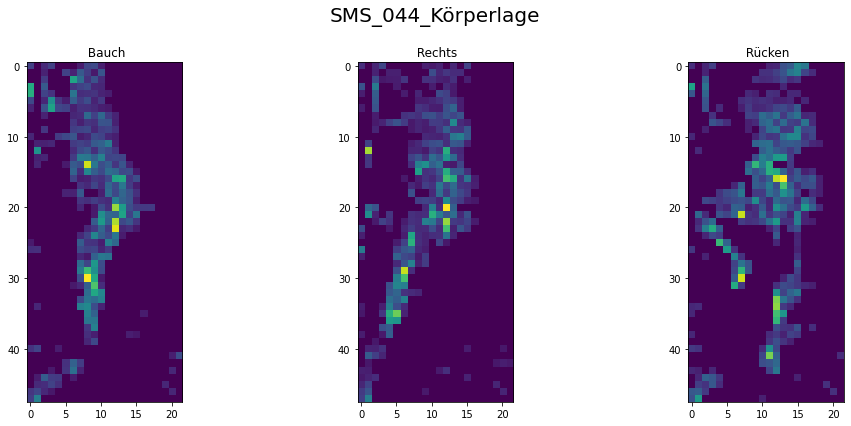

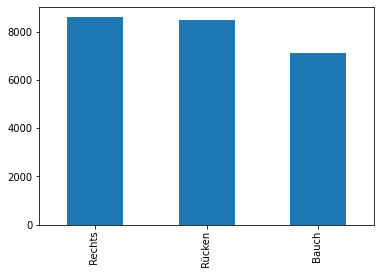

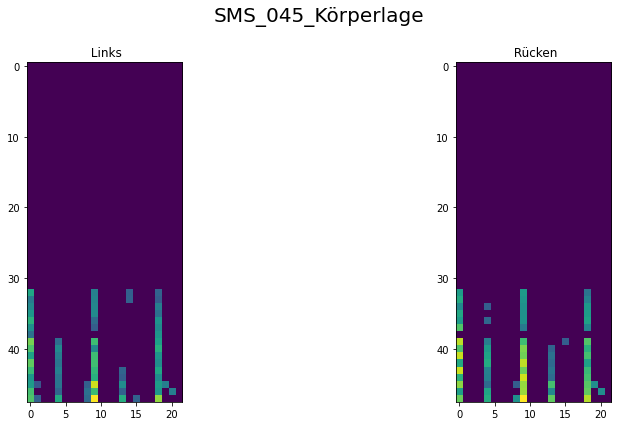

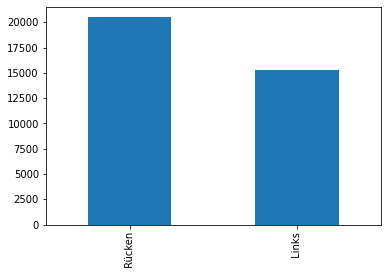

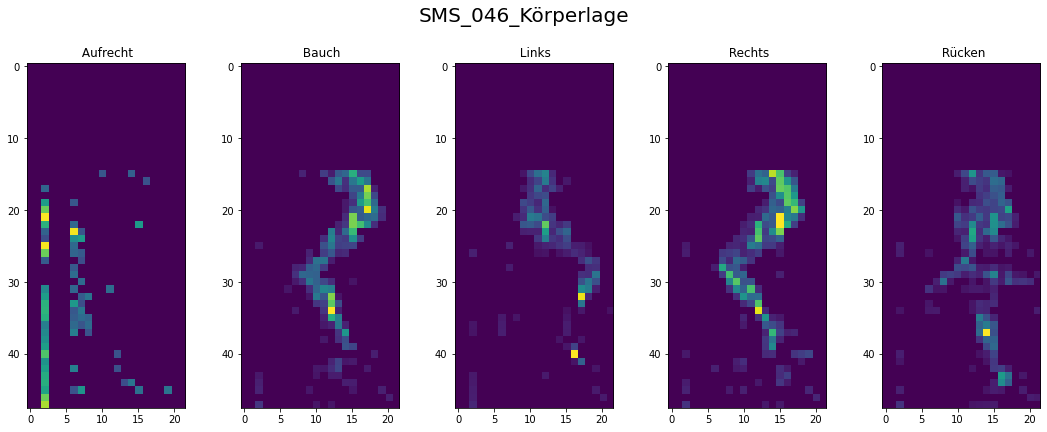

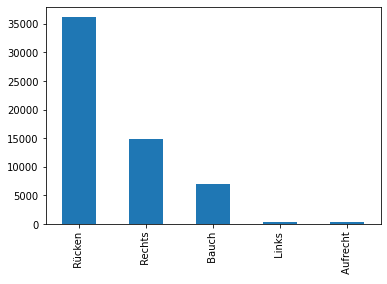

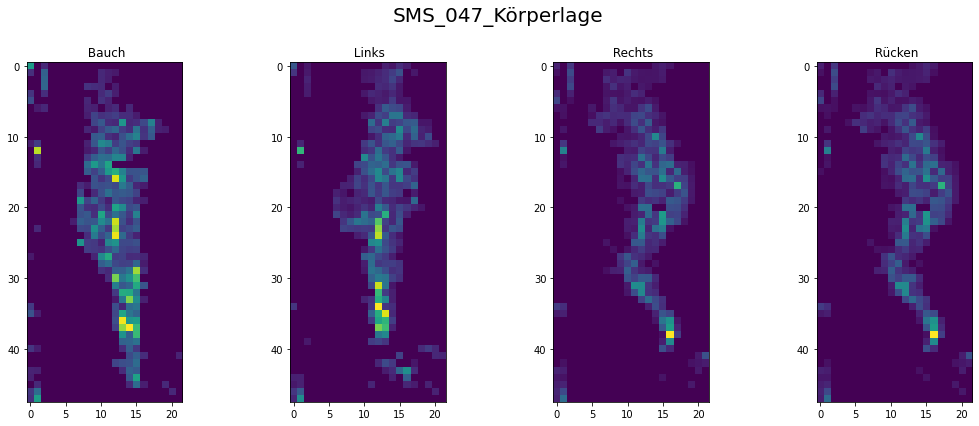

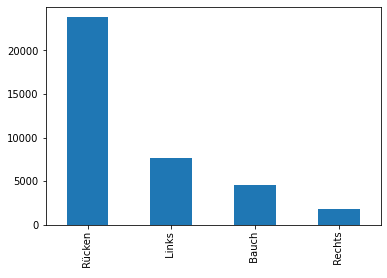

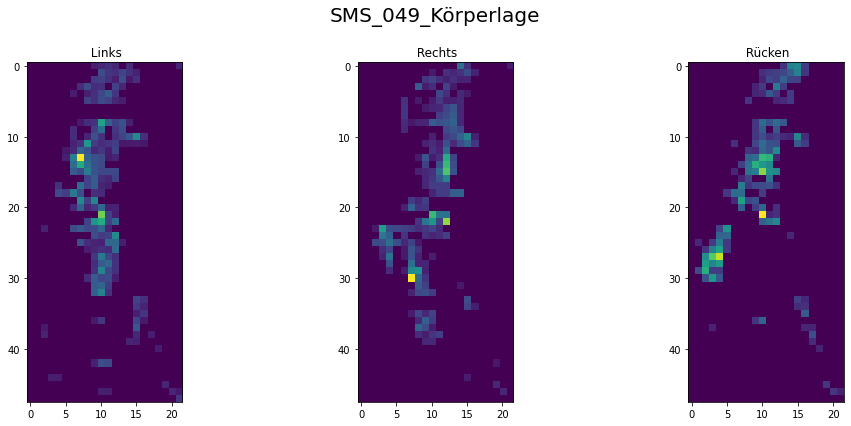

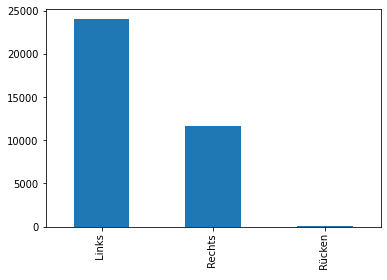

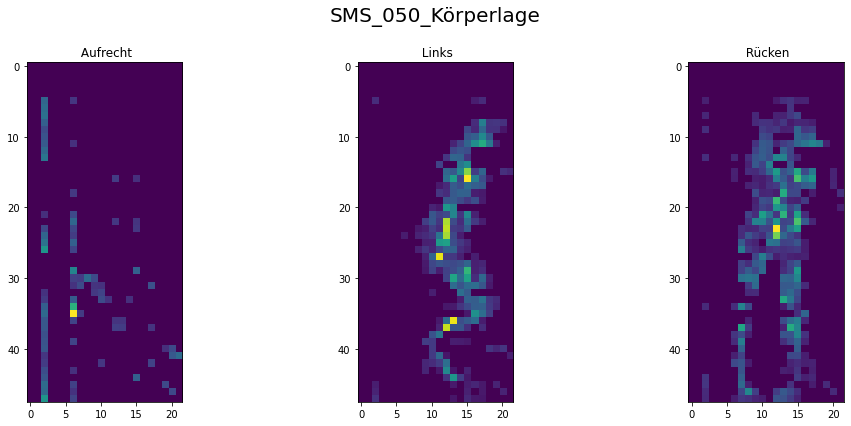

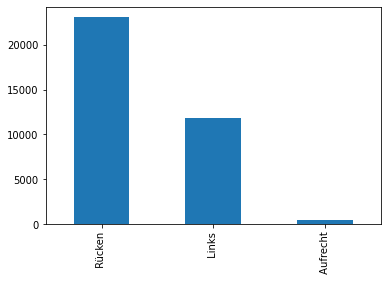

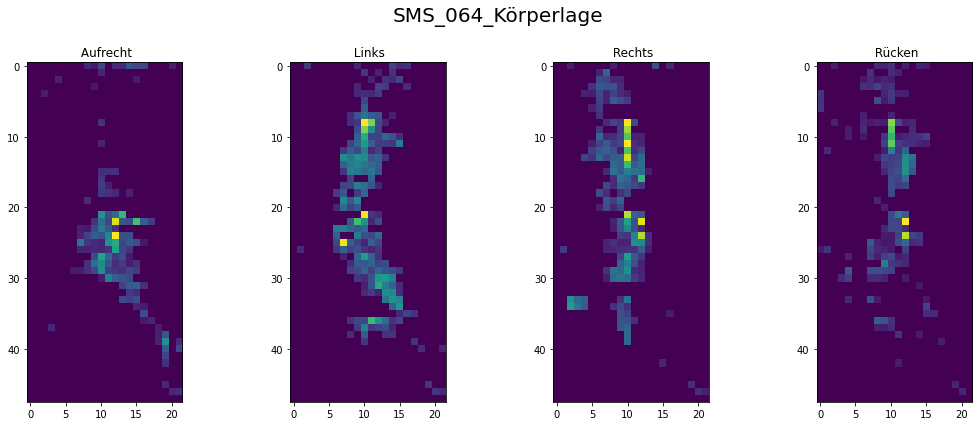

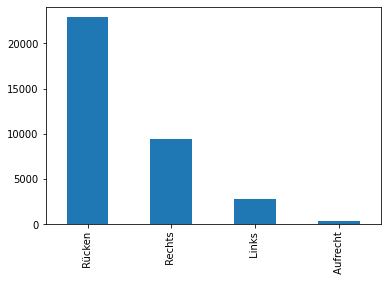

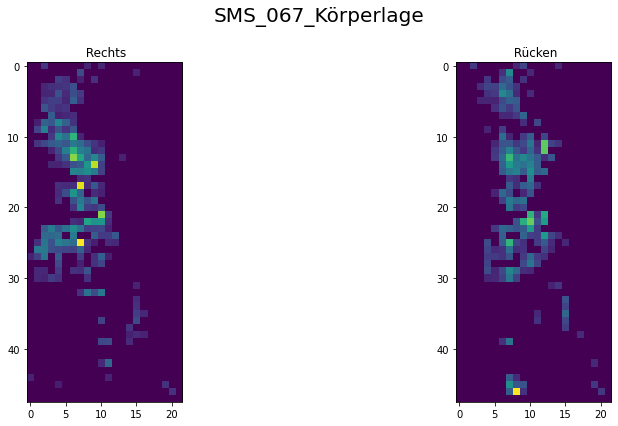

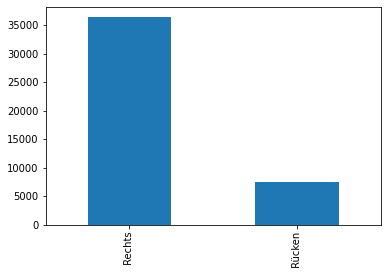

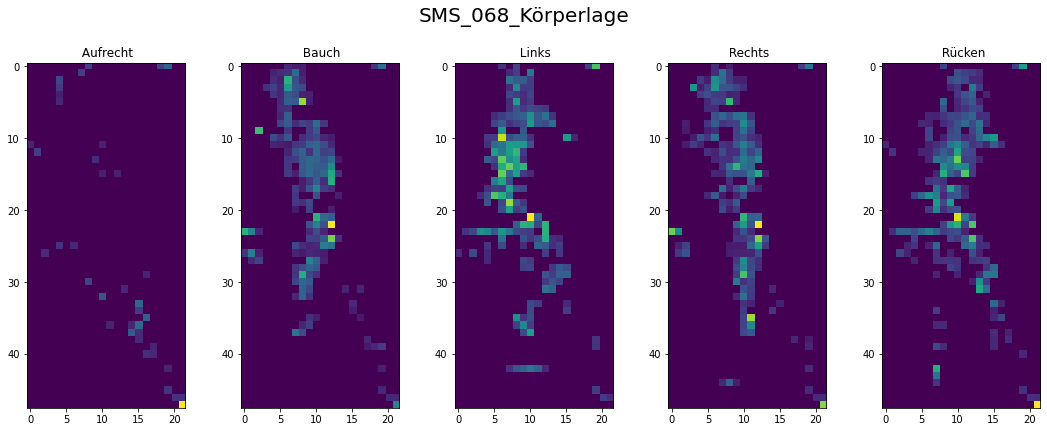

no data for SMS_070_Körperlage


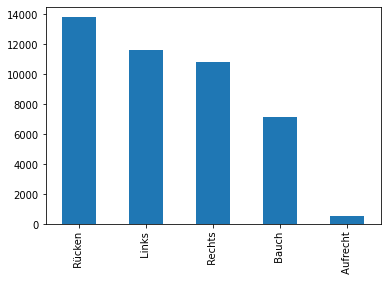

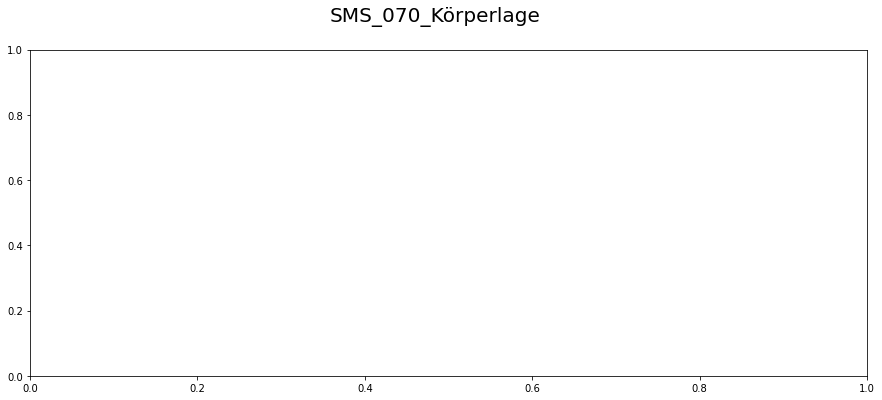

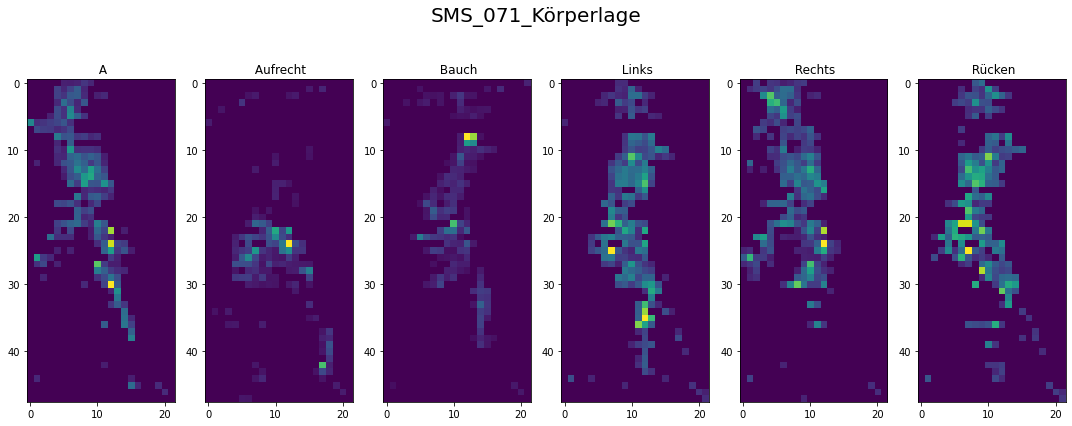

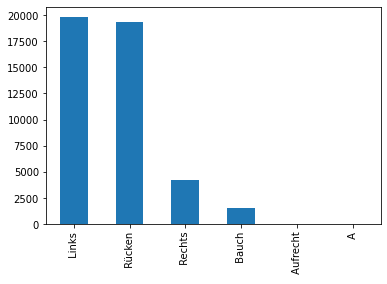

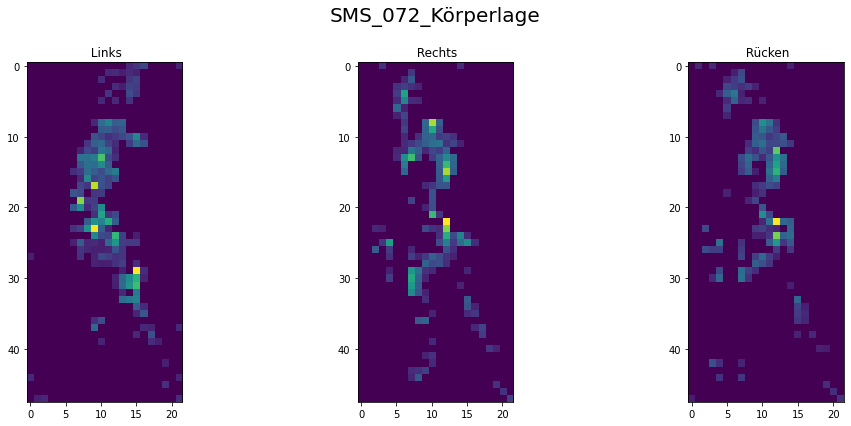

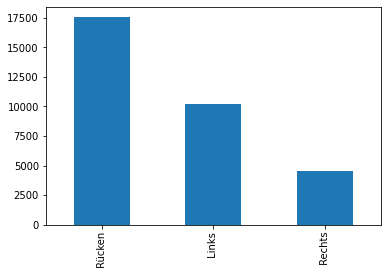

In [33]:
image_dir = os.getcwd()+'\image'
for tx, lb in zip(txt, dt):
    try:
        df_merged, df_end = get_image(tx,lb)
    except:
        print(f'no data for',tx[-22:-4])

Here is the unique label for this patient [' Links' ' Rechts' ' Bauch' ' Rücken' ' Aufrecht']


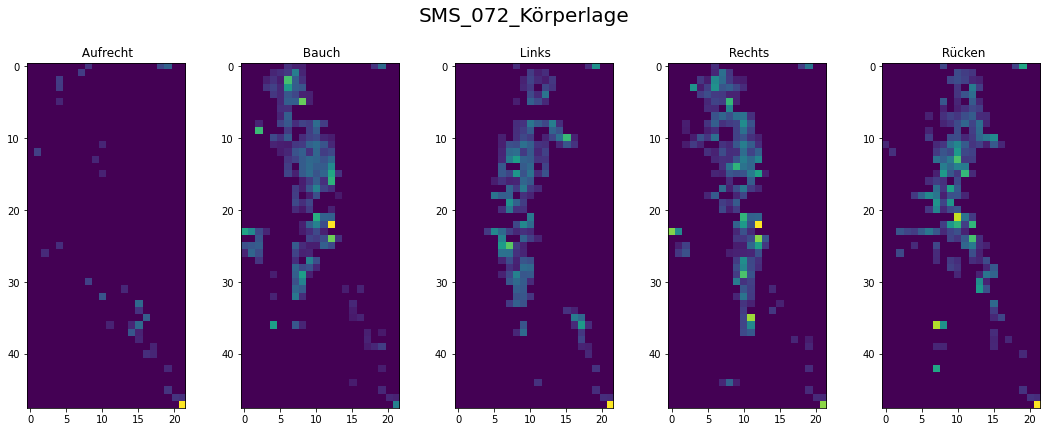

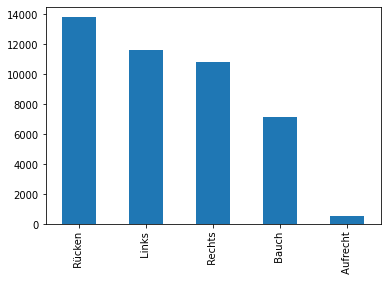

In [144]:
df_merged, df_end = get_image(txt[10],dt[10])

Here is the unique label for this patient [' Rücken' ' Rechts' ' Aufrecht' ' Bauch']


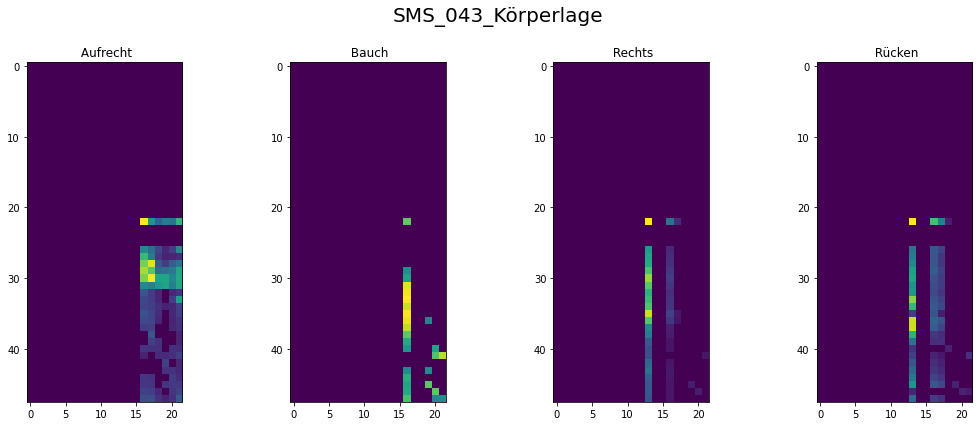

Here is the unique label for this patient [' Rücken' ' Bauch' ' Rechts']


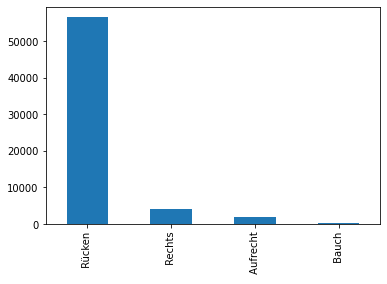

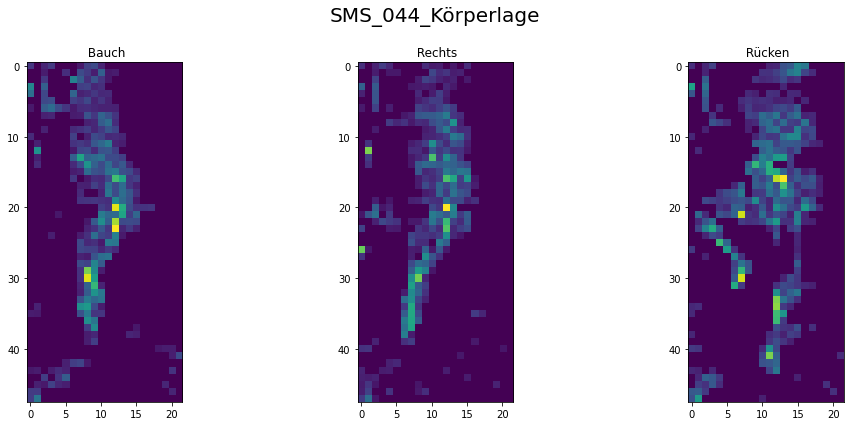

Here is the unique label for this patient [' Links' ' Rücken']


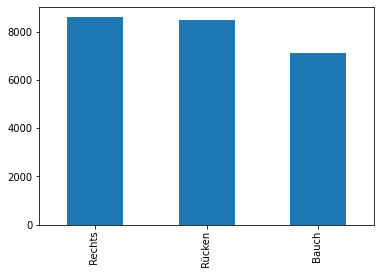

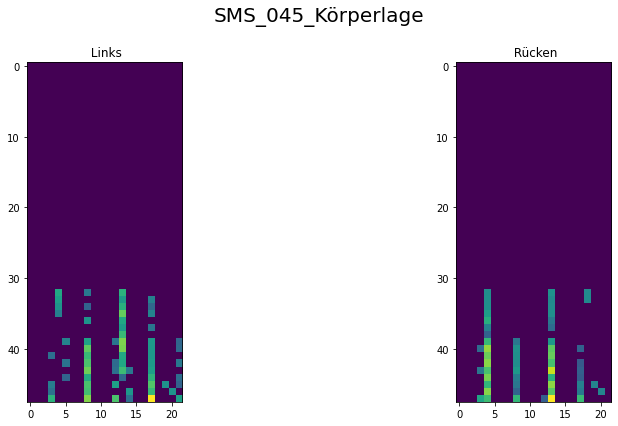

Here is the unique label for this patient [' Rücken' ' Links' ' Rechts' ' Aufrecht' ' Bauch']


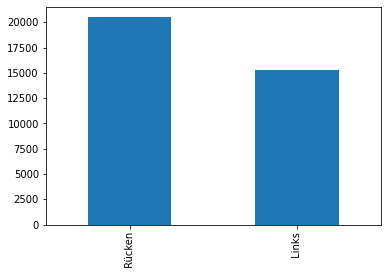

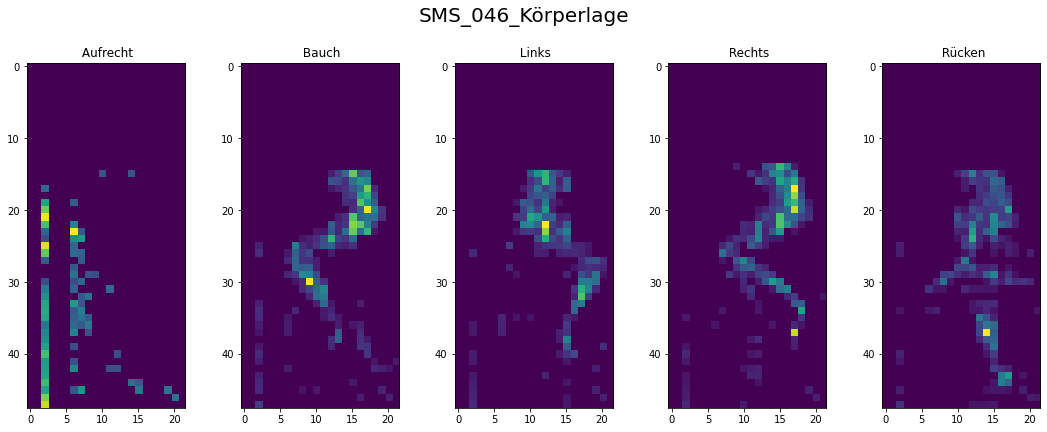

Here is the unique label for this patient [' Rechts' ' Rücken' ' Links' ' Bauch']


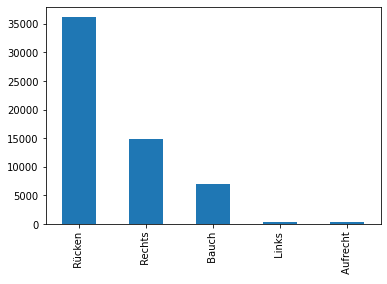

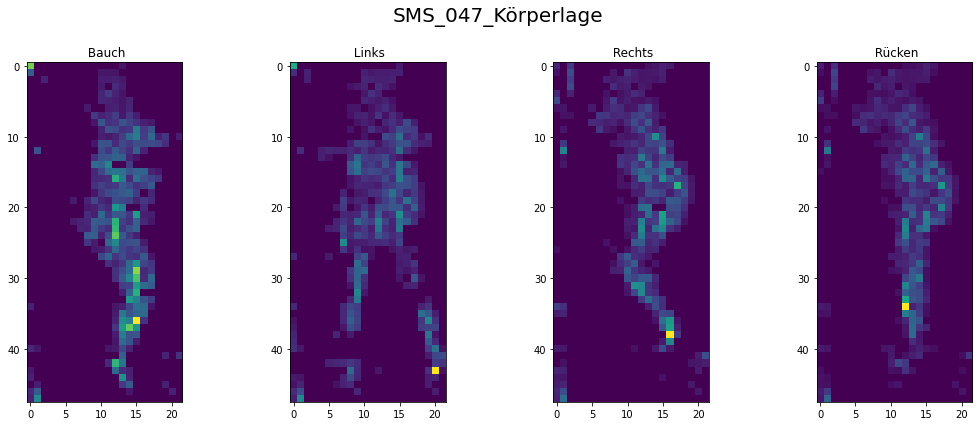

Here is the unique label for this patient [' Rechts' ' Rücken' ' Links']


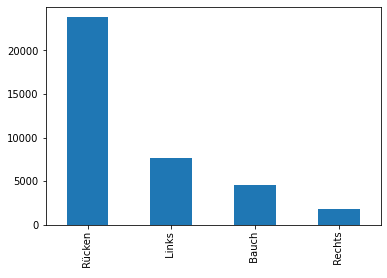

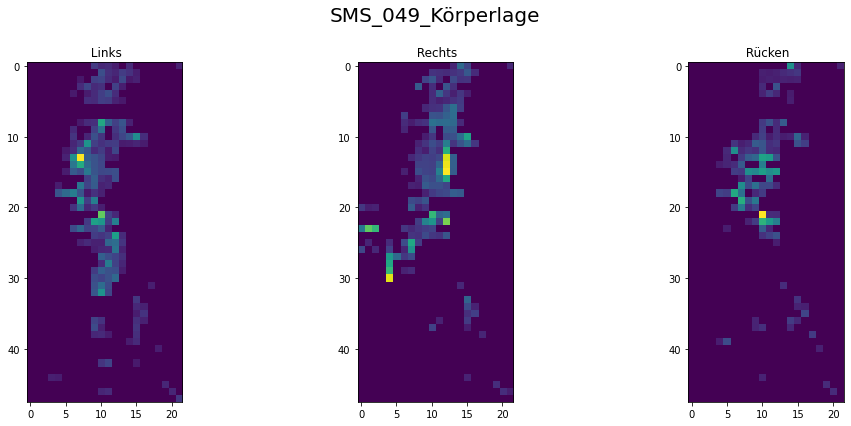

Here is the unique label for this patient [' Rücken' ' Links' ' Aufrecht']


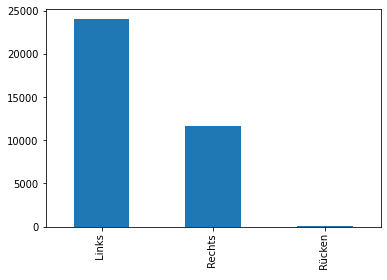

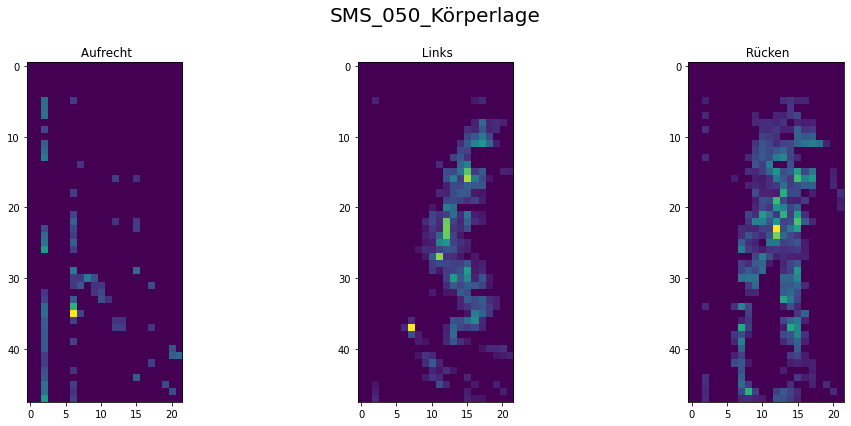

Here is the unique label for this patient [' Rechts' ' Links' ' Aufrecht' ' Rücken']


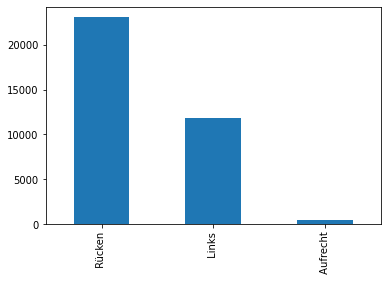

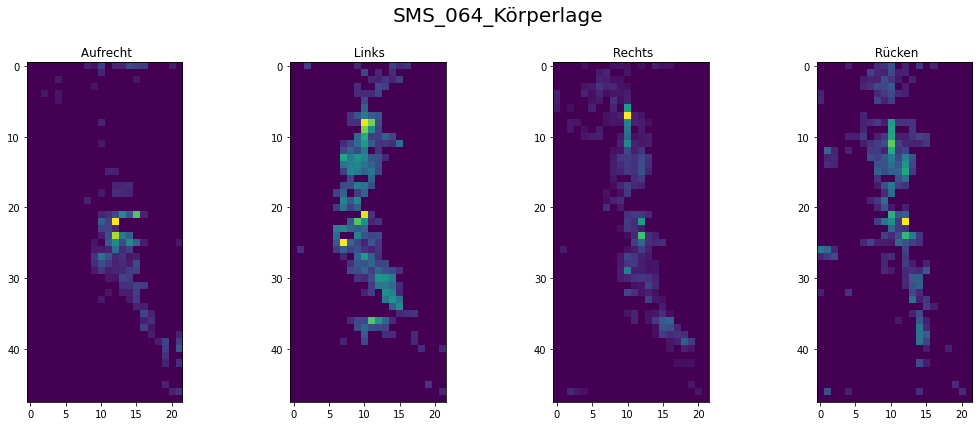

Here is the unique label for this patient [' Rechts' ' Rücken']


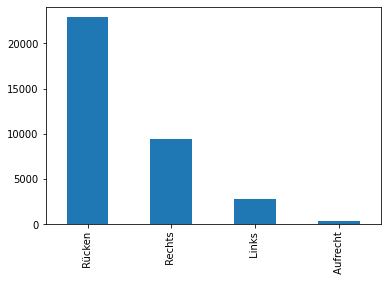

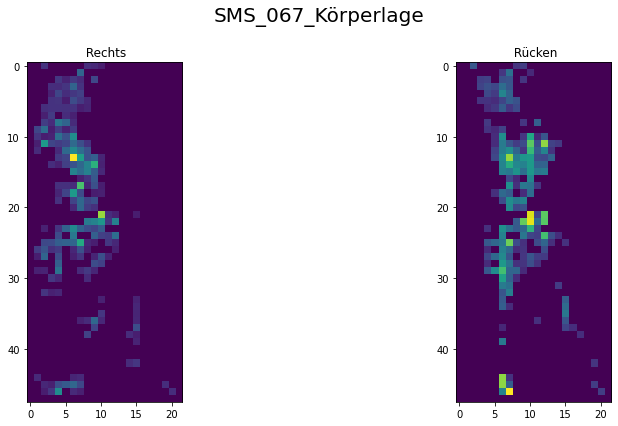

Here is the unique label for this patient [' Links' ' Rechts' ' Bauch' ' Rücken' ' Aufrecht']


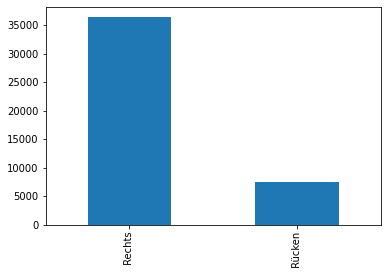

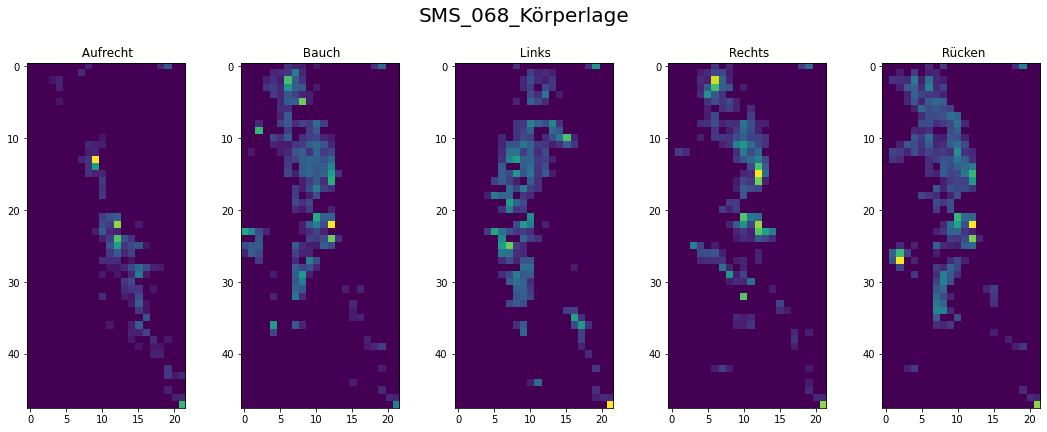

Here is the unique label for this patient [' Links']
no data for SMS_070_Körperlage
no data for SMS_071_Körperlage
Here is the unique label for this patient [' Links' ' Rücken' ' Rechts']


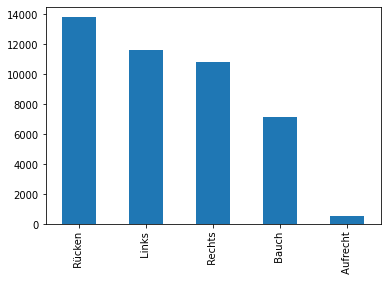

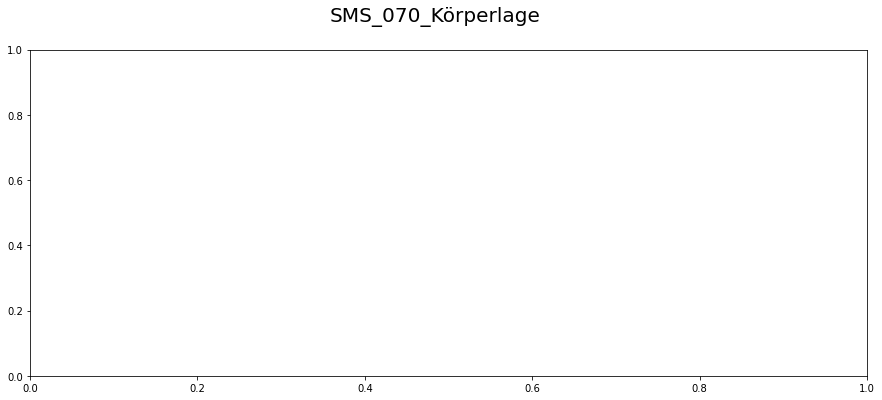

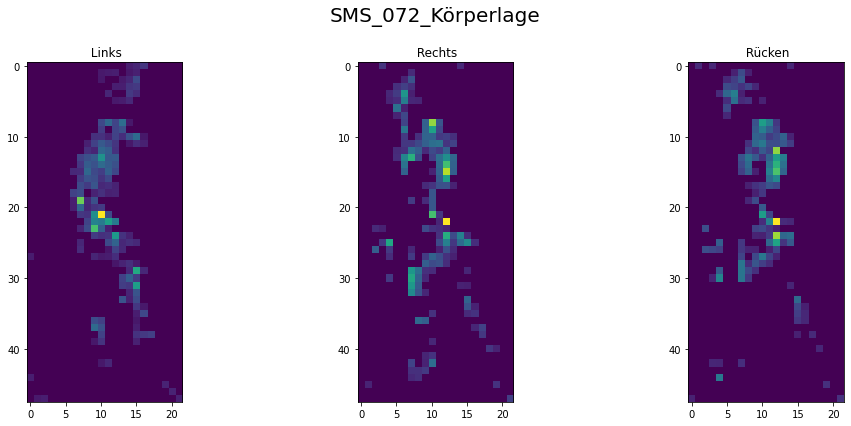

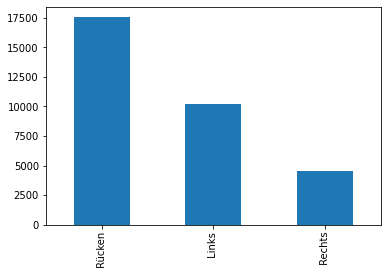

In [82]:
image_dir = os.getcwd()+'\image'
for tx, lb in zip(txt, dt):
    try:
        df_merged, df_end = get_image(tx,lb)
    except:
        print(f'no data for',tx[-22:-4])

Here is the unique label for this patient [' Rücken' ' Rechts' ' Aufrecht' ' Bauch']


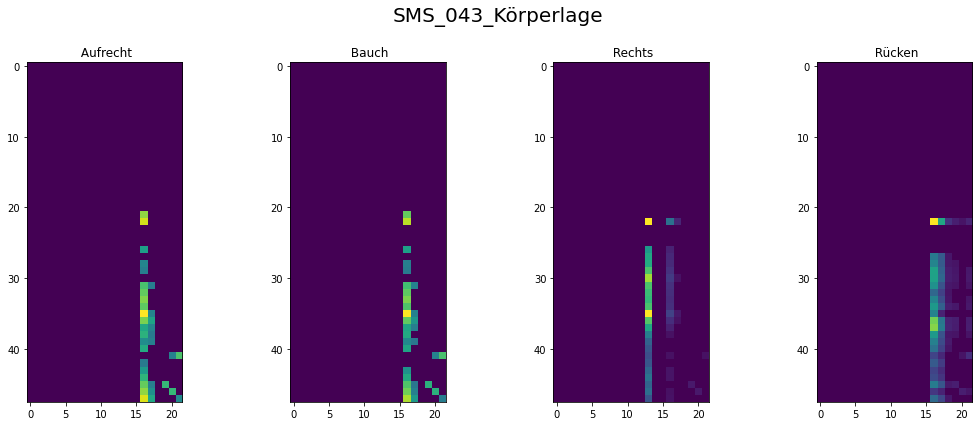

Here is the unique label for this patient [' Rücken' ' Bauch' ' Rechts']


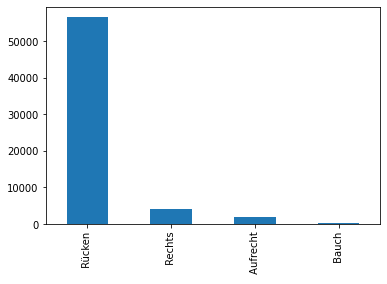

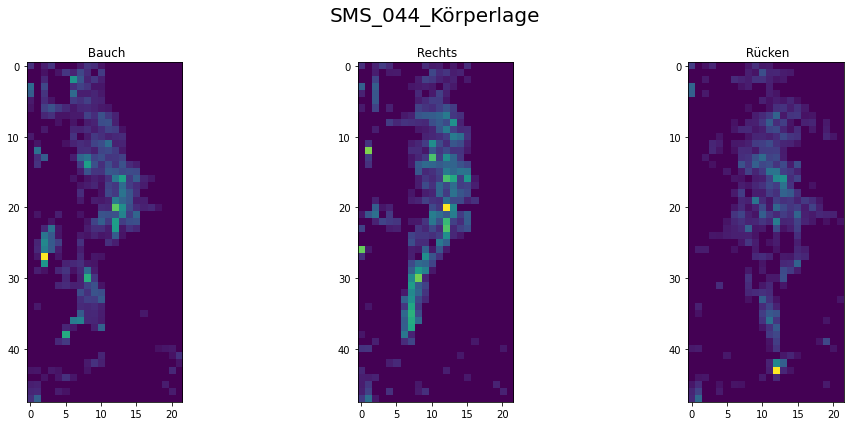

Here is the unique label for this patient [' Links' ' Rücken']


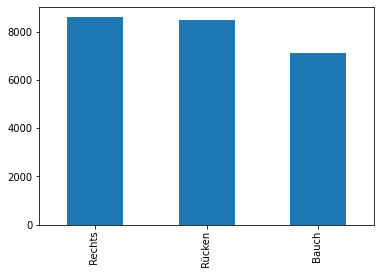

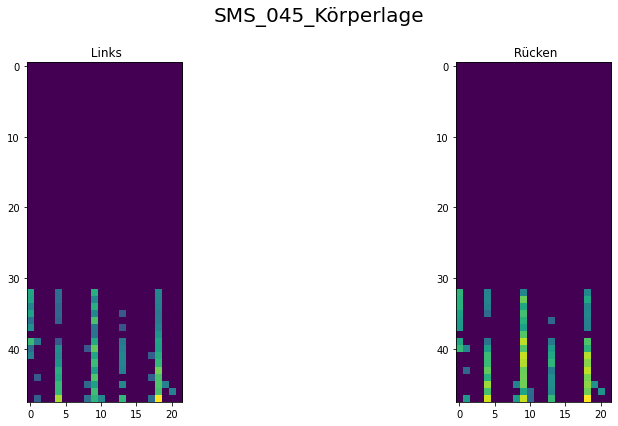

Here is the unique label for this patient [' Rücken' ' Links' ' Rechts' ' Aufrecht' ' Bauch']


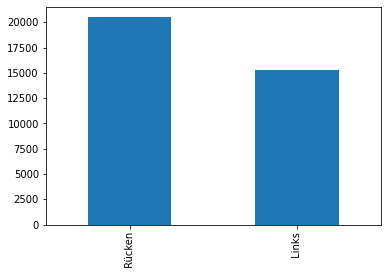

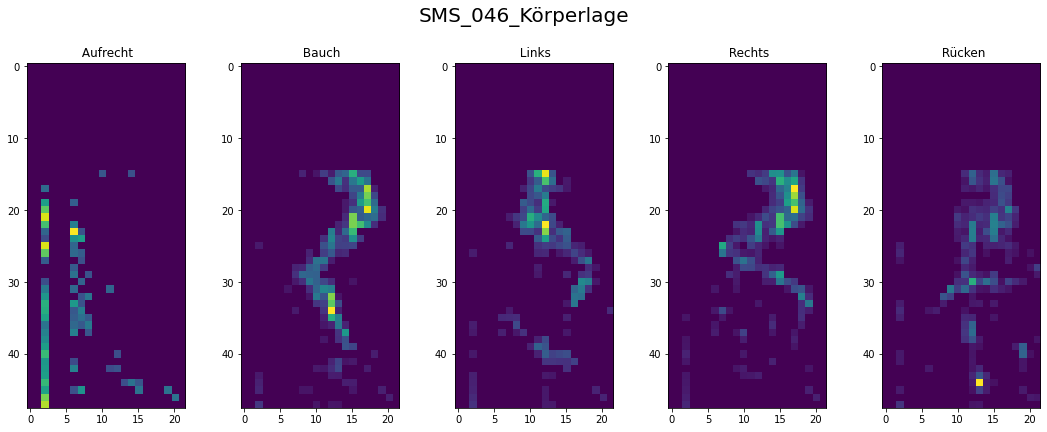

Here is the unique label for this patient [' Rechts' ' Rücken' ' Links' ' Bauch']


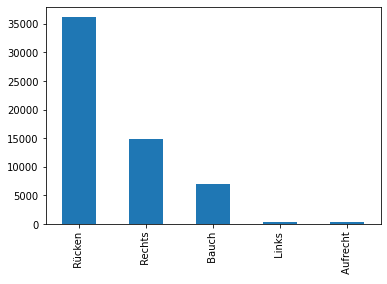

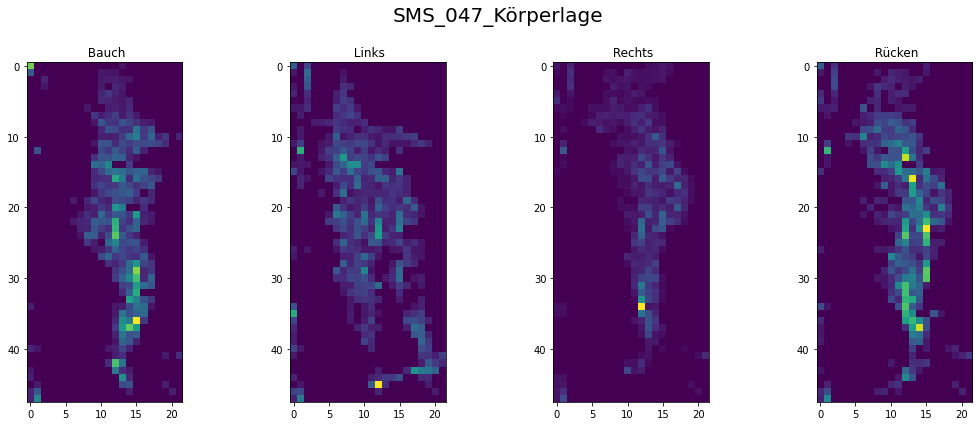

Here is the unique label for this patient [' Rechts' ' Rücken' ' Links']


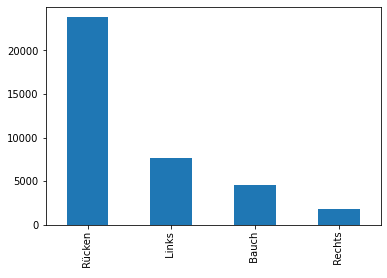

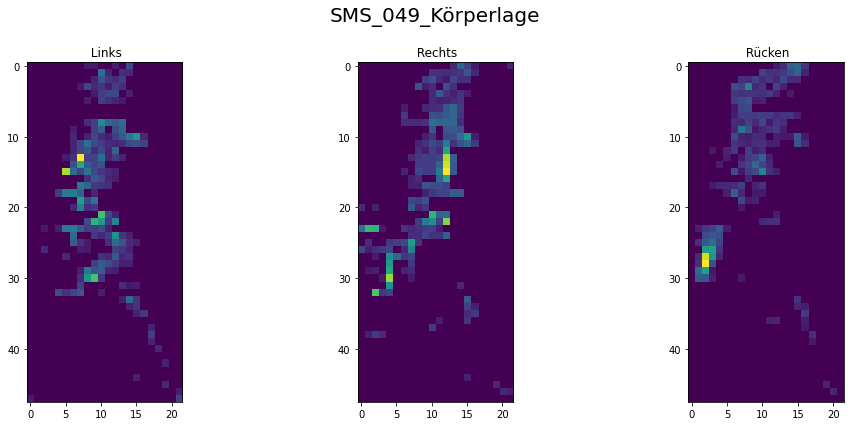

Here is the unique label for this patient [' Rücken' ' Links' ' Aufrecht']


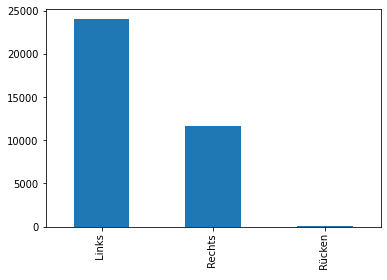

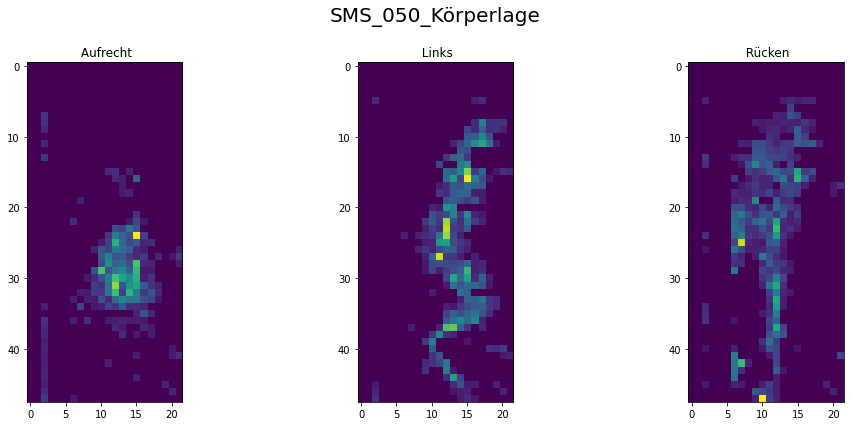

Here is the unique label for this patient [' Rechts' ' Links' ' Aufrecht' ' Rücken']


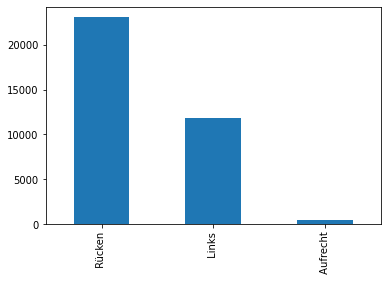

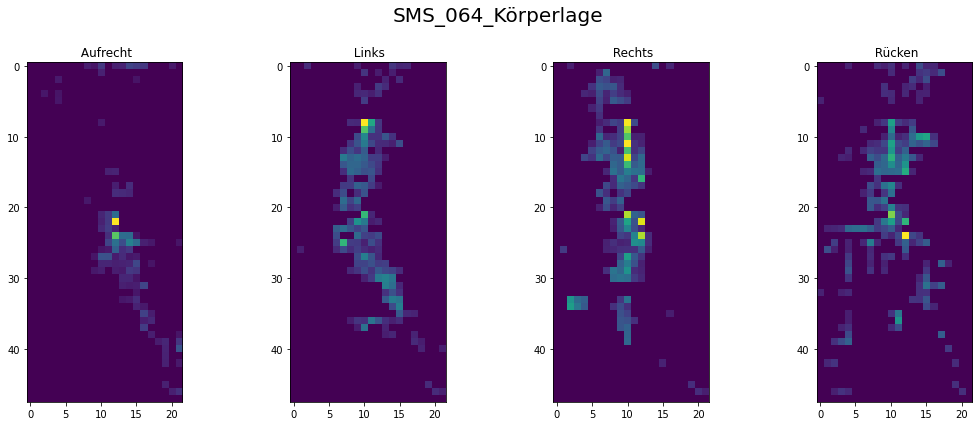

Here is the unique label for this patient [' Rechts' ' Rücken']


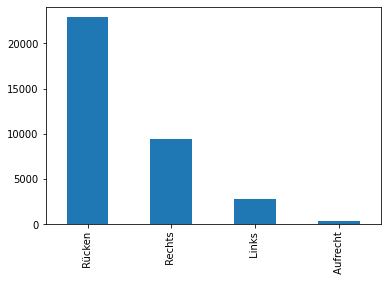

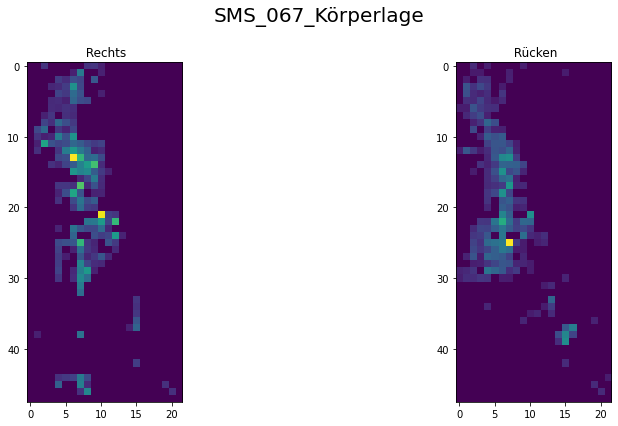

Here is the unique label for this patient [' Links' ' Rechts' ' Bauch' ' Rücken' ' Aufrecht']


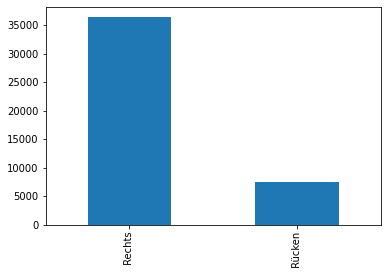

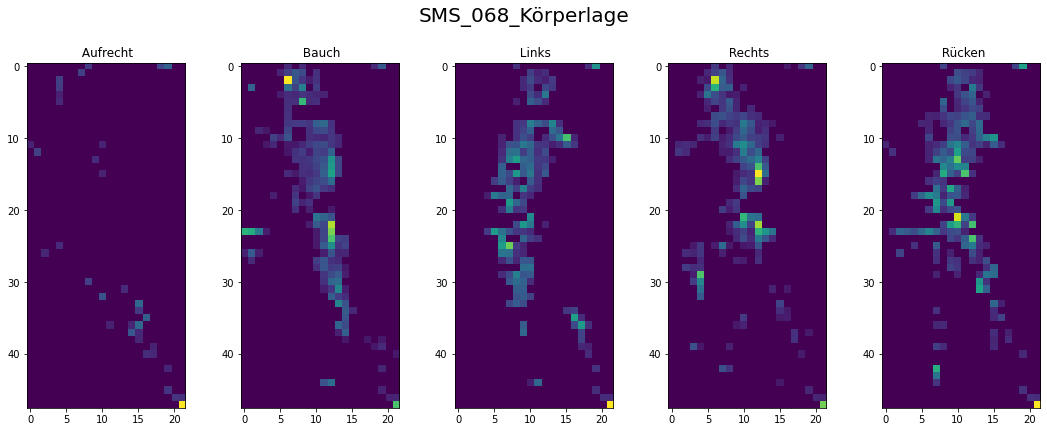

Here is the unique label for this patient [' Links']
no data for SMS_070_Körperlage
no data for SMS_071_Körperlage
Here is the unique label for this patient [' Links' ' Rücken' ' Rechts']


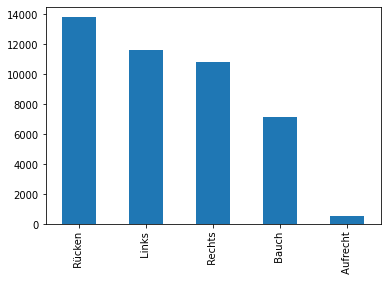

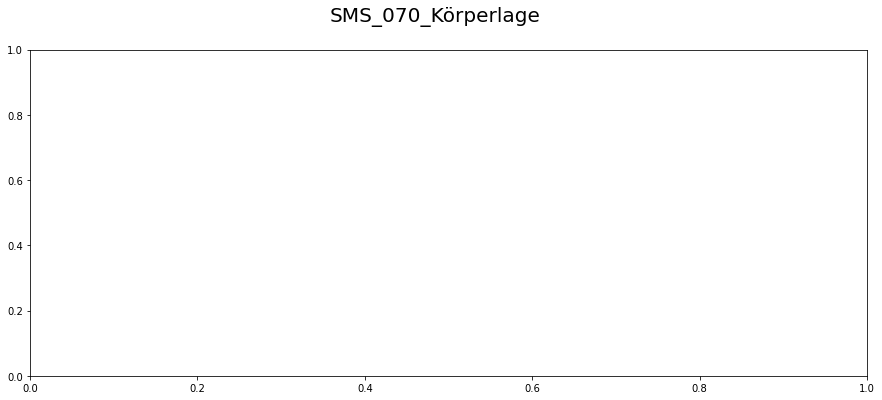

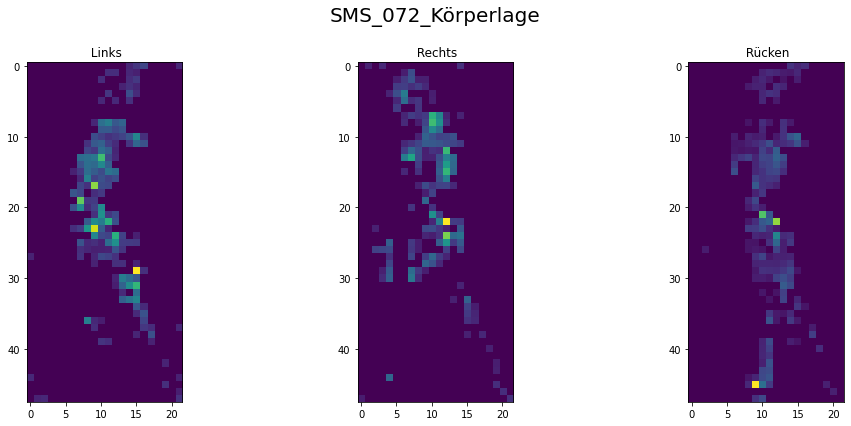

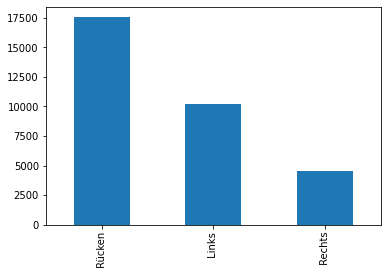

In [105]:
image_dir = os.getcwd()+'\image'
for tx, lb in zip(txt, dt):
    try:
        df_merged, df_end = get_image(tx,lb)
    except:
        print(f'no data for',tx[-22:-4])

In [89]:
print(dt[0])

c:\Users\phili\techlabs\eth_sms\Data\SMS_033-psg-Sensingtex-processed.pkl


In [90]:
get_data(dt[0])

,time,pressure,end,label
0,2021-12-03 23:46:25.221,"[[0.0, 0.0, 0.0, 0.0, 61.0, 0.0, 0.0, 0.0, 0.0...",2021-12-03 23:46:25.823,0
1,2021-12-03 23:46:25.823,"[[0.0, 0.0, 0.0, 0.0, 63.0, 0.0, 0.0, 0.0, 0.0...",2021-12-03 23:46:26.525,0
2,2021-12-03 23:46:26.525,"[[0.0, 0.0, 0.0, 0.0, 63.0, 0.0, 0.0, 0.0, 0.0...",2021-12-03 23:46:27.227,0
3,2021-12-03 23:46:27.227,"[[0.0, 0.0, 0.0, 0.0, 63.0, 0.0, 0.0, 0.0, 0.0...",2021-12-03 23:46:27.828,0
4,2021-12-03 23:46:27.828,"[[0.0, 0.0, 0.0, 0.0, 65.0, 0.0, 0.0, 0.0, 0.0...",2021-12-03 23:46:28.430,0
...,...,...,...,...
37251,2021-12-04 06:09:57.454,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2021-12-04 06:09:58.063,0
37252,2021-12-04 06:09:58.063,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2021-12-04 06:09:58.665,0
37253,2021-12-04 06:09:58.665,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2021-12-04 06:09:59.267,0
37254,2021-12-04 06:09:59.267,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2021-12-04 06:09:59.769,0


In [13]:
# df_merged[df_merged['label']==' Bauch']
# r_show = df_merged[df_merged['label']==' Bauch']
# plt.imshow(r_show['pressure'].iloc[0])

Why do we have 0 label? because start for data and label are different

In [118]:
df_merged, df_end = get_label(txt[0],dt[0])

In [119]:
df_merged

,time,pressure,end,label
0,2021-12-03 23:46:25.221,"[[0.0, 0.0, 0.0, 0.0, 61.0, 0.0, 0.0, 0.0, 0.0...",2021-12-03 23:46:25.823,Bauch
1,2021-12-03 23:46:25.823,"[[0.0, 0.0, 0.0, 0.0, 63.0, 0.0, 0.0, 0.0, 0.0...",2021-12-03 23:46:26.525,Bauch
2,2021-12-03 23:46:26.525,"[[0.0, 0.0, 0.0, 0.0, 63.0, 0.0, 0.0, 0.0, 0.0...",2021-12-03 23:46:27.227,Bauch
3,2021-12-03 23:46:27.227,"[[0.0, 0.0, 0.0, 0.0, 63.0, 0.0, 0.0, 0.0, 0.0...",2021-12-03 23:46:27.828,Bauch
4,2021-12-03 23:46:27.828,"[[0.0, 0.0, 0.0, 0.0, 65.0, 0.0, 0.0, 0.0, 0.0...",2021-12-03 23:46:28.430,Bauch
...,...,...,...,...
37250,2021-12-04 06:09:56.852,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2021-12-04 06:09:57.454,0
37251,2021-12-04 06:09:57.454,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2021-12-04 06:09:58.063,0
37252,2021-12-04 06:09:58.063,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2021-12-04 06:09:58.665,0
37253,2021-12-04 06:09:58.665,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2021-12-04 06:09:59.267,0


In [257]:
df_merged, df_end = get_label(txt[0],dt[0])

In [258]:
df_merged.head(5)

,time,pressure,end,label
0,2022-01-24 21:42:29.116,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 21:42:29.617,0
1,2022-01-24 21:42:29.617,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 21:42:30.119,0
2,2022-01-24 21:42:30.119,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 21:42:30.621,0
3,2022-01-24 21:42:30.621,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 21:42:59.425,0
4,2022-01-24 21:42:59.425,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 21:42:59.926,0


In [262]:
df_merged[df_merged['label']==0]

,time,pressure,end,label
0,2022-01-24 21:42:29.116,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 21:42:29.617,0
1,2022-01-24 21:42:29.617,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 21:42:30.119,0
2,2022-01-24 21:42:30.119,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 21:42:30.621,0
3,2022-01-24 21:42:30.621,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 21:42:59.425,0
4,2022-01-24 21:42:59.425,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 21:42:59.926,0
...,...,...,...,...
3040,2022-01-24 22:12:54.087,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 22:12:54.589,0
3041,2022-01-24 22:12:54.589,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 22:12:55.190,0
3042,2022-01-24 22:12:55.190,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 22:12:55.692,0
3043,2022-01-24 22:12:55.692,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-24 22:12:56.194,0


In [263]:
df_end

,time,Position,end
0,2022-01-24 22:12:56.500,Rücken,2022-01-24 22:23:01.250
1,2022-01-24 22:23:01.250,A,2022-01-24 22:23:04.000
2,2022-01-24 22:23:04.000,Rücken,2022-01-25 00:15:26.750
3,2022-01-25 00:15:26.750,Rechts,2022-01-25 00:52:49.500
4,2022-01-25 00:52:49.500,Rücken,2022-01-25 01:03:53.000
5,2022-01-25 01:03:53.000,Aufrecht,2022-01-25 01:07:43.750
6,2022-01-25 01:07:43.750,Bauch,2022-01-25 01:09:51.500
7,2022-01-25 01:09:51.500,Aufrecht,2022-01-25 01:11:54.250
8,2022-01-25 01:11:54.250,Bauch,2022-01-25 01:12:01.500
9,2022-01-25 01:12:01.500,Aufrecht,2022-01-25 01:17:35.750


In [265]:
df_merged.iloc[9999]

time                               2022-01-24 23:21:42.932000
pressure    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
end                                2022-01-24 23:21:43.333000
label                                                  Rücken
Name: 9999, dtype: object

In [177]:
df_merged[df_merged['label']==0]

,time,pressure,end,label


In [91]:
label = extract_label(txt[0])


In [92]:
label

,time,Position,end
0,2021-03-12 23:17:43.000,Rücken,2021-03-12 23:26:44.500
1,2021-03-12 23:26:44.500,A,2021-03-12 23:26:47.000
2,2021-03-12 23:26:47.000,Rücken,2021-03-12 23:30:28.241
3,2021-03-12 23:30:28.241,A,2021-03-12 23:30:30.750
4,2021-03-12 23:30:30.750,Rücken,2021-03-12 23:34:28.500
5,2021-03-12 23:34:28.500,Aufrecht,2021-03-12 23:36:36.500
6,2021-03-12 23:36:36.500,Rücken,2021-03-12 23:38:52.750
7,2021-03-12 23:38:52.750,Rechts,2021-03-12 23:39:04.750
8,2021-03-12 23:39:04.750,Bauch,2021-03-12 23:41:56.750
9,2021-03-12 23:41:56.750,Rücken,2021-03-12 23:43:08.241


In [99]:
data = get_data(dt[0])

In [95]:
data

,time,pressure,end,label
0,2021-12-03 23:46:25.221,"[[0.0, 0.0, 0.0, 0.0, 61.0, 0.0, 0.0, 0.0, 0.0...",2021-12-03 23:46:25.823,0
1,2021-12-03 23:46:25.823,"[[0.0, 0.0, 0.0, 0.0, 63.0, 0.0, 0.0, 0.0, 0.0...",2021-12-03 23:46:26.525,0
2,2021-12-03 23:46:26.525,"[[0.0, 0.0, 0.0, 0.0, 63.0, 0.0, 0.0, 0.0, 0.0...",2021-12-03 23:46:27.227,0
3,2021-12-03 23:46:27.227,"[[0.0, 0.0, 0.0, 0.0, 63.0, 0.0, 0.0, 0.0, 0.0...",2021-12-03 23:46:27.828,0
4,2021-12-03 23:46:27.828,"[[0.0, 0.0, 0.0, 0.0, 65.0, 0.0, 0.0, 0.0, 0.0...",2021-12-03 23:46:28.430,0
...,...,...,...,...
37251,2021-12-04 06:09:57.454,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2021-12-04 06:09:58.063,0
37252,2021-12-04 06:09:58.063,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2021-12-04 06:09:58.665,0
37253,2021-12-04 06:09:58.665,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2021-12-04 06:09:59.267,0
37254,2021-12-04 06:09:59.267,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2021-12-04 06:09:59.769,0


In [97]:
print(dt[12])

c:\Users\phili\techlabs\eth_sms\Data\SMS_071-psg-Sensingtex-processed.pkl


In [98]:
data = get_data(dt[12])

EOFError: Ran out of input

In [176]:
data = get_data(dt[8])
label = extract_label(txt[8])

In [267]:
label = extract_label(txt[0])

In [34]:
data = get_data(dt[3])

In [96]:
dx = get_data(dt[3])

In [97]:
dx

,time,pressure,end,label
0,2022-01-17 22:53:06.412,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-17 22:53:07.014,0
1,2022-01-17 22:53:07.014,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-17 22:53:07.616,0
2,2022-01-17 22:53:07.616,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-17 22:53:08.117,0
3,2022-01-17 22:53:08.117,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-17 22:53:08.719,0
4,2022-01-17 22:53:08.719,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-17 22:53:09.321,0
...,...,...,...,...
58751,2022-01-18 08:25:56.410,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-18 08:25:57.011,0
58752,2022-01-18 08:25:57.011,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-18 08:25:57.613,0
58753,2022-01-18 08:25:57.613,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-18 08:25:58.215,0
58754,2022-01-18 08:25:58.215,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-18 08:25:58.820,0


In [35]:
data

,time,pressure,end,label
0,2022-01-17 21:53:06.412,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-17 21:53:07.014,0
1,2022-01-17 21:53:07.014,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-17 21:53:07.616,0
2,2022-01-17 21:53:07.616,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-17 21:53:08.117,0
3,2022-01-17 21:53:08.117,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-17 21:53:08.719,0
4,2022-01-17 21:53:08.719,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-17 21:53:09.321,0
...,...,...,...,...
58751,2022-01-18 07:25:56.410,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-18 07:25:57.011,0
58752,2022-01-18 07:25:57.011,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-18 07:25:57.613,0
58753,2022-01-18 07:25:57.613,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-18 07:25:58.215,0
58754,2022-01-18 07:25:58.215,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-18 07:25:58.820,0


In [179]:
data.tail(5)

,time,pressure,end,label
35408,2022-03-19 04:29:57.367,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 0.0, 0.0...",2022-03-19 04:29:57.868,0
35409,2022-03-19 04:29:57.868,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 0.0, 0.0...",2022-03-19 04:29:58.370,0
35410,2022-03-19 04:29:58.370,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 0.0, 0.0...",2022-03-19 04:29:58.871,0
35411,2022-03-19 04:29:58.871,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 66.0, 0.0, 0.0...",2022-03-19 04:29:59.372,0
35412,2022-03-19 04:29:59.372,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 66.0, 0.0, 0.0...",2022-03-19 04:29:59.372,0


Here, you can see that pkl file start 1 hour later compare to label file

In [60]:
txt[9]

'c:\\Users\\phili\\techlabs\\eth_sms\\labels\\SMS_068_Körperlage.txt'

In [146]:
label[label['Position']==' Bauch']

,time,Position,end
36,2022-03-19 05:33:39,Bauch,2022-03-19 05:33:39


In [143]:
label.Position.unique()

array([' A', ' Rücken', ' Aufrecht', ' Rechts', ' Links', ' Bauch'],
      dtype=object)

In [183]:
df_merged.iloc[24786] #

time                               2022-03-19 02:43:17.322000
pressure    [[0.0, 0.0, 0.0, 0.0, 70.0, 0.0, 0.0, 0.0, 101...
end                                2022-03-19 02:43:17.924000
label                                                  Rechts
Name: 24786, dtype: object

Read EDF file

In [17]:
import mne

In [82]:
# https://stackoverflow.com/questions/51869713/how-to-read-edf-data-in-python-3
edf_fname = r'C:\Users\phili\techlabs\eth_sms\UNI85088612959895_(1).edf'
# edf_raw = mne.io.read_raw_edf(edf_fname, preload=True)
edf_raw = mne.io.read_raw_edf(edf_fname)
raw_data = edf_raw.get_data()
info = edf_raw.info
channels = edf_raw.ch_names



Extracting EDF parameters from C:\Users\phili\techlabs\eth_sms\UNI85088612959895_(1).edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [83]:
raw_data.shape

(45, 6728192)

In [86]:
raw_data[5]

array([1.        , 1.00225863, 1.00903045, ..., 6.        , 6.        ,
       6.        ])

Which channel of edf to export dataset like in pkl file?

In [20]:
len(edf_raw.ch_names)

45

Duplicate timestamp in pickle file

In [39]:
def get_rawdata(dt):
    data = pd.read_pickle(dt)
    data = data.reset_index()
    data = data.rename(columns={"index": "time", "matData": "pressure"})
    data['time'] = pd.to_datetime(data['time'],unit='ms')
    # df_new = data.drop_duplicates(subset='time', keep='first').reset_index().drop(columns= ['index']) #drop with exact date and hours and get the first one
    df_new = data
    df_new['end'] = df_new['time'].shift(-1) # get the duration
    df_new['end'] = np.where(df_new['end'].isnull(), df_new['time'], df_new['end'])
    df_new['label'] = 0
    return df_new

In [40]:
data = get_rawdata(dt[2])

In [41]:
data

,time,pressure,end,label
0,2022-01-19 23:59:44.891,"[[118.0, 0.0, 83.0, 182.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-19 23:59:44.891,0
1,2022-01-19 23:59:44.891,"[[117.0, 0.0, 82.0, 182.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-19 23:59:45.593,0
2,2022-01-19 23:59:45.593,"[[117.0, 0.0, 84.0, 182.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-19 23:59:45.593,0
3,2022-01-19 23:59:45.593,"[[116.0, 0.0, 83.0, 181.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-19 23:59:46.195,0
4,2022-01-19 23:59:46.195,"[[116.0, 0.0, 82.0, 182.0, 0.0, 0.0, 0.0, 0.0,...",2022-01-19 23:59:46.195,0
...,...,...,...,...
47358,2022-01-20 04:29:57.443,"[[94.0, 0.0, 77.0, 134.0, 0.0, 0.0, 0.0, 0.0, ...",2022-01-20 04:29:58.145,0
47359,2022-01-20 04:29:58.145,"[[94.0, 0.0, 75.0, 134.0, 0.0, 0.0, 0.0, 0.0, ...",2022-01-20 04:29:58.145,0
47360,2022-01-20 04:29:58.145,"[[94.0, 0.0, 75.0, 135.0, 0.0, 0.0, 0.0, 0.0, ...",2022-01-20 04:29:58.847,0
47361,2022-01-20 04:29:58.847,"[[93.0, 0.0, 77.0, 133.0, 0.0, 0.0, 0.0, 0.0, ...",2022-01-20 04:29:58.847,0


In [46]:
(data['pressure'][0] == data['pressure'][1]).all() #check if pressure on 2022-01-19 23:59:44.891 for first entry and second entry exact the same

False

In [44]:
test

,time,pressure,end,label
0,2022-01-20 04:29:58.145,"[[94.0, 0.0, 75.0, 134.0, 0.0, 0.0, 0.0, 0.0, ...",2022-01-20 04:29:58.145,0
1,2022-01-20 04:29:58.145,"[[94.0, 0.0, 75.0, 135.0, 0.0, 0.0, 0.0, 0.0, ...",2022-01-20 04:29:58.847,0


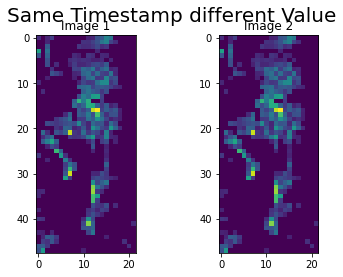

In [43]:
test = data[data['time'] == '2022-01-20 04:29:58.145'].reset_index().drop(columns=['index'])
fig, (ax1, ax2) = plt.subplots(1,2)

fig.suptitle('Same Timestamp different Value', fontsize=20)

# Line plots
ax1.set_title('Image 1')
ax1.imshow(test['pressure'][0])

ax2.set_title('Image 2')
ax2.imshow(test['pressure'][0])



In [77]:
df_merged.label.nunique()

4

Number of dataset vs duplicate timestamp

<AxesSubplot:>

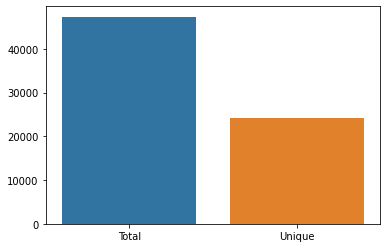

In [51]:
raw_data = {
    'x': ['Total','Unique'],
    'y': [len(data.time),  len(data.drop_duplicates(subset='time', keep='first'))]
           }

sns.barplot(x='x', y='y', data=raw_data)

Make Video

In [270]:
# import numpy as np
# import cv2
# size = 720*16//9, 720
# duration = 2
# fps = 25
# out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]), False)
# for _ in range(fps * duration):
#     data = np.random.randint(0, 256, size, dtype='uint8')
#     out.write(data)
# out.release()

In [61]:
df_merged, df_end = get_label(txt[9],dt[9])

In [62]:
img = []
lbl = []
for i in range(0, len(df_merged['pressure'])):
    img.append(df_merged['pressure'][i])
    lbl.append(df_merged['label'][i])


In [63]:
df_merged.label.unique()

array([' Links', ' Rechts', ' Bauch', ' Rücken', ' Aufrecht'],
      dtype=object)

In [64]:
df_merged[df_merged['label']==' Bauch'].head(100)

,time,pressure,end,label
4049,2022-03-17 23:00:24.835,"[[0.0, 0.0, 439.0, 0.0, 97.0, 0.0, 0.0, 0.0, 6...",2022-03-17 23:00:25.437,Bauch
4050,2022-03-17 23:00:25.437,"[[0.0, 0.0, 429.0, 0.0, 71.0, 0.0, 0.0, 0.0, 6...",2022-03-17 23:00:25.939,Bauch
4051,2022-03-17 23:00:25.939,"[[0.0, 0.0, 411.0, 0.0, 65.0, 0.0, 0.0, 0.0, 6...",2022-03-17 23:00:26.541,Bauch
4052,2022-03-17 23:00:26.541,"[[0.0, 0.0, 368.0, 0.0, 0.0, 0.0, 0.0, 0.0, 95...",2022-03-17 23:00:27.143,Bauch
4053,2022-03-17 23:00:27.143,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 89.0, 0.0, 133...",2022-03-17 23:00:27.745,Bauch
...,...,...,...,...
4144,2022-03-17 23:01:22.814,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 0.0, 161...",2022-03-17 23:01:23.422,Bauch
4145,2022-03-17 23:01:23.422,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 0.0, 162...",2022-03-17 23:01:24.024,Bauch
4146,2022-03-17 23:01:24.024,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.0, 0.0, 161...",2022-03-17 23:01:24.726,Bauch
4147,2022-03-17 23:01:24.726,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 0.0, 162...",2022-03-17 23:01:25.428,Bauch


In [66]:
df_merged.tail(5)

,time,pressure,end,label
43828,2022-03-18 05:39:56.968,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 124.0, 77.0, 7...",2022-03-18 05:39:57.369,Bauch
43829,2022-03-18 05:39:57.369,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 123.0, 77.0, 7...",2022-03-18 05:39:57.971,Bauch
43830,2022-03-18 05:39:57.971,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 121.0, 76.0, 7...",2022-03-18 05:39:58.573,Bauch
43831,2022-03-18 05:39:58.573,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 121.0, 76.0, 7...",2022-03-18 05:39:59.175,Bauch
43832,2022-03-18 05:39:59.175,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 121.0, 75.0, 7...",2022-03-18 05:39:59.175,Bauch


In [65]:
df_end

,time,Position,end
0,2022-03-17 22:05:12.240,A,2022-03-17 22:05:12.241
1,2022-03-17 22:05:12.241,Rücken,2022-03-17 22:20:00.500
2,2022-03-17 22:20:00.500,Links,2022-03-17 22:47:55.000
3,2022-03-17 22:47:55.000,Rechts,2022-03-17 23:00:24.500
4,2022-03-17 23:00:24.500,Bauch,2022-03-17 23:33:04.250
5,2022-03-17 23:33:04.250,Links,2022-03-17 23:33:36.000
6,2022-03-17 23:33:36.000,Rücken,2022-03-18 00:44:17.500
7,2022-03-18 00:44:17.500,Links,2022-03-18 02:08:40.500
8,2022-03-18 02:08:40.500,Rücken,2022-03-18 02:58:14.000
9,2022-03-18 02:58:14.000,Aufrecht,2022-03-18 03:02:48.250


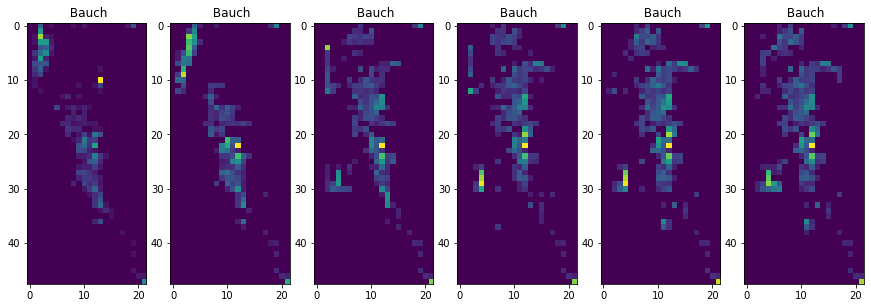

In [50]:
fig, axs = plt.subplots(1,6,figsize=(15, 6),)
for i in range(6):

    axs[i].set_title(df_merged['label'][i*10+4050])
    axs[i].imshow(df_merged['pressure'][i*10+4050])

In [69]:
df_merged[df_merged['label']==' Aufrecht']

,time,pressure,end,label
27322,2022-03-18 02:58:14.176,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 204....",2022-03-18 02:58:14.678,Aufrecht
27323,2022-03-18 02:58:14.678,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 205....",2022-03-18 02:58:15.280,Aufrecht
27324,2022-03-18 02:58:15.280,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 63.0, 0.0, 224...",2022-03-18 02:58:15.782,Aufrecht
27325,2022-03-18 02:58:15.782,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 104.0, 0.0, 23...",2022-03-18 02:58:16.384,Aufrecht
27326,2022-03-18 02:58:16.384,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 109....",2022-03-18 02:58:16.986,Aufrecht
...,...,...,...,...
27829,2022-03-18 03:02:45.825,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 135....",2022-03-18 03:02:46.427,Aufrecht
27830,2022-03-18 03:02:46.427,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 136....",2022-03-18 03:02:47.029,Aufrecht
27831,2022-03-18 03:02:47.029,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 135....",2022-03-18 03:02:47.531,Aufrecht
27832,2022-03-18 03:02:47.531,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 128....",2022-03-18 03:02:48.033,Aufrecht


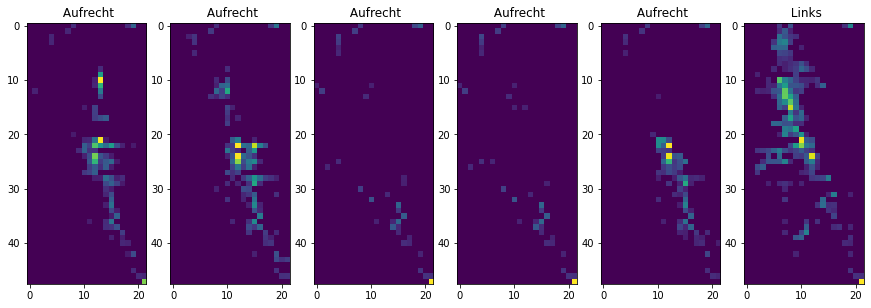

In [72]:
fig, axs = plt.subplots(1,6,figsize=(15, 6),)
for i in range(6):

    axs[i].set_title(df_merged['label'][i*125+27330])
    axs[i].imshow(df_merged['pressure'][i*125+27330])

In [22]:
import cv2
img2 = np.zeros( ( np.array(img).shape[0], np.array(img).shape[1], 3 ) )
img2[:,:,0] = img # same value in each channel
img2[:,:,1] = img
img2[:,:,2] = img
cv2.imshow('image',img2)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [194]:
# import cv2
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# img2 = np.zeros_like(img)
# img2[:,:,0] = gray
# img2[:,:,1] = gray
# img2[:,:,2] = gray

cv2.circle(img2, (10,10), 5, (255,255,0))
cv2.imshow("colour again", img2)
cv2.waitKey()

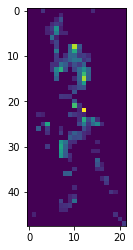

In [136]:
plt.imshow(df_merged['pressure'].iloc[-1])

In [54]:
merged_dir = os.getcwd()+'\video'
for tx, lb in zip(txt, dt):
    try:
        df_merged, df_end = get_label(tx,lb)
        img = []
        lbl = []
        for i in range(0, len(df_merged['pressure'])):
            img.append(df_merged['pressure'][i])
            lbl.append(df_merged['label'][i])

        size = img[0].shape
        fps = 100

        # initialize video writer
        out = cv2.VideoWriter(f'video/{tx[-22:-4]}.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]),False)

        for im, lb in zip(img, lbl):
            im = im.astype(np.uint8)
            im = cv2.normalize(im, None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            im_3c = cv2.merge([im, im, im])
            out.write(im)
        out.release()
        
    except EOFError:
        print(f'no data for',tx[-22:-4])

no data for SMS_071_Körperlage


In [68]:
import numpy as np
import cv2
size = img[0].shape
fps = 100

# initialize video writer
out = cv2.VideoWriter('output_%.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]),False)

for im, lb in zip(img, lbl):
    im = im.astype(np.uint8)
    im = cv2.normalize(im, None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
        """Return a sharpened version of the image, using an unsharp mask."""
        blurred = cv2.GaussianBlur(image, kernel_size, sigma)
        sharpened = float(amount + 1) * image - float(amount) * blurred
        sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
        sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
        sharpened = sharpened.round().astype(np.uint8)
        if threshold > 0:
            low_contrast_mask = np.absolute(image - blurred) < threshold
            np.copyto(sharpened, image, where=low_contrast_mask)
        return sharpened
    im = unsharp_mask(im)
    im_3c = cv2.merge([im, im, im])
    out.write(im)
out.release()

In [ ]:
# import numpy as np
# import cv2
# size = img[0].shape
# fps = 100

# # initialize video writer
# # video_filename = 'nextoutput.avi'
# # fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
# # out = cv2.VideoWriter(video_filename, fourcc, fps, (size[1], size[0]),False)
# out = cv2.VideoWriter('output_%.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]),False)
# # for _ in range(fps * duration):
# # for im in img:
# for im, lb in zip(img, lbl):
#     # data = np.random.randint(0, 256, size, dtype='uint8')
#     # out.write(data)
#     im = im.astype(np.uint8)
#     im = cv2.normalize(im, None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     # # font
#     # font = cv2.FONT_HERSHEY_SIMPLEX
#     # # org
#     # org = (10, 10)
#     # # fontScale
#     # fontScale = 5
#     # # White color in BGR
#     # color = (255,255,255)
#     # # Line thickness of 2 px
#     # thickness = 2
#     # # Using cv2.putText() method
#     # # im = cv2.putText(im, lb, org, font, 
#     #                 # fontScale, color, thickness)
#     # font = cv2.FONT_HERSHEY_SIMPLEX
#     # im = cv2.putText(frame, 
#     #             'LSS', 
#     #             (10, 10), 
#     #             font, 1, 
#     #             (0), 
#     #             1, 
#     #             cv2.LINE_4)
#     # # im = cv2.medianBlur(im, 5)
#     # im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     im_3c = cv2.merge([im, im, im])
#     out.write(im)
# out.release()

In [168]:
# import numpy as np
# import cv2
# size = img[0].shape
# fps = 100

# # initialize video writer
# # video_filename = 'nextoutput.avi'
# # fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
# # out = cv2.VideoWriter(video_filename, fourcc, fps, (size[1], size[0]),False)
# out = cv2.VideoWriter('output_%.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]),False)
# # for _ in range(fps * duration):
# # for im in img:
# for im, lb in zip(img, lbl):
#     # data = np.random.randint(0, 256, size, dtype='uint8')
#     # out.write(data)
#     im = im.astype(np.uint8)
#     im = cv2.normalize(im, None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     # # font
#     # font = cv2.FONT_HERSHEY_SIMPLEX
#     # # org
#     # org = (10, 10)
#     # # fontScale
#     # fontScale = 5
#     # # White color in BGR
#     # color = (255,255,255)
#     # # Line thickness of 2 px
#     # thickness = 2
#     # # Using cv2.putText() method
#     # # im = cv2.putText(im, lb, org, font, 
#     #                 # fontScale, color, thickness)
#     # font = cv2.FONT_HERSHEY_SIMPLEX
#     # im = cv2.putText(frame, 
#     #             'LSS', 
#     #             (10, 10), 
#     #             font, 1, 
#     #             (0), 
#     #             1, 
#     #             cv2.LINE_4)
d
#     # im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     im_3c = cv2.merge([im, im, im])
#     out.write(im)
# out.release()